In [ ]:
#Data retrieval process and defining libs 

import numpy as np 
import torchvision 
import torch
import os
import random 
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torchvision.transforms as transforms
TRAIN_ON_GPU = torch.cuda.is_available()
losses = []
train_value = []

train_acc_val = []
train_loss_val = []
iteration = []  

if(TRAIN_ON_GPU):
    print('Training on GPU!')

num_workers = 0
batch_size = 20

transform = transforms.ToTensor()

train_data = torchvision.datasets.MNIST(root = '/data', train = True, download = True, transform = transform)
test_data = torchvision.datasets.MNIST(root = '/data', train = False, download = True, transform = transform)

train_loader = torchvision.torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers)
test_loader  = torchvision.torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

def softmax(input_tensor, dim=1):
    # transpose input
    transposed_input = input_tensor.transpose(dim, len(input_tensor.size()) - 1)
    # calculate softmax
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    # un-transpose result
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input_tensor.size()) - 1)

#Squash function 
def squash(u):
  norm = (u ** 2).sum(-1, keepdim=True)
  denom = ((1. + norm) * torch.sqrt(norm))
  if torch.isinf(denom).sum().item()>0:
    squash_output = u / torch.sqrt(norm)
  else:
    squash_output = norm * u / ((1. + norm) * torch.sqrt(norm))
  return squash_output

Training on GPU!


**Encoder network bold text**

In [ ]:
#The encoder layer before Primary Capsule 
class ConvLayer(nn.Module):
  def __init__(self, in_channels = 1, out_channels = 256):
    super(ConvLayer, self).__init__()
    self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 9, stride = 1, padding = 0)
    
  def forward(self, x):
    out = F.relu(self.conv(x))
    return out


**Primary Capsules**

In [ ]:
class PrimaryCapsule(nn.Module):
  def __init__(self, num_capsules = 8, in_channels = 256, out_channels = 32):
    super(PrimaryCapsule, self).__init__()
    self.capsules = nn.ModuleList([nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 9, stride = 2, padding = 0) for _ in range(0, num_capsules)])
    
  def forward(self, x):
    u = [capsule(x).view(batch_size, 32 * 6 * 6, 1) for capsule in self.capsules]
    u = torch.cat(u, dim=-1)
    # squashing the stack of vectors
    out_squash = squash(u)
    return out_squash


**Dynamic routing** - Don't use this



In [ ]:
def dynamic_routing(b_ij, u_hat, iterations=3):
    for i in range(0, iterations):
        c_ij = softmax(b_ij, dim=2)

        # calculating total capsule inputs
        s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

        # squashing to get a normalized vector output, v_j
        v_j = squash(s_j)

        # if not on the last iteration, calculate agreement and new b_ij
        if i < iterations - 1:
            # agreement
            a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
            
            # new b_ij
            b_ij = b_ij + a_ij
    
    return v_j # return latest v_j


**Digit Capsules**

In [ ]:
class DigitCapsule(nn.Module):
  def __init__(self, num_capsules = 10, num_routes = 32*6*6, in_channels = 8, out_channels = 16):
    super(DigitCapsule, self).__init__()
    #Weight i-j (connecting the primary capsule and the digit capsules)
    self.W = nn.Parameter(torch.randn(num_capsules, num_routes, in_channels, out_channels))

  def forward(self, u):
    u = u[None, :, : , None, :]
    W = self.W[:, None, :, :, :]
    u_hat = torch.matmul(u, W)
    b_ij = torch.zeros(*u_hat.size())
    if TRAIN_ON_GPU:
      b_ij = b_ij.cuda()
      u_hat = u_hat.cuda()
    '''b_ij.to(device)
    u_hat.to(device)'''
    iterations = 3
    for i in range(0, iterations):
      c_ij = softmax(b_ij, dim=2)
      if TRAIN_ON_GPU:
          c_ij = c_ij.cuda()
      # calculating total capsule inputs
      s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)
      # squashing to get a normalized vector output, v_j
      v_j = squash(s_j)
      # if not on the last iteration, calculate agreement and new b_ij
      if i < iterations - 1:
        # agreement
        a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
        # new b_ij
        b_ij = b_ij + a_ij

    return v_j 

**Decoder for DigitCapsules**

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_vector=16, num_capsules=10, hidden_dim=512):
        super(Decoder, self).__init__()
        # calculate input_dim
        input_dim = in_vector * num_capsules
        
        #Dense layers for decoder network
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # first hidden layer
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim*2, 28*28), # can be reshaped into 28*28 image
            nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
            )
        
    def forward(self, x):
        classes = (x ** 2).sum(dim=-1) ** 0.5
        #classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        # Identify the capsule with maximum vector length - indicating the probability of each class
        _, max_length_indices = classes.max(dim=1)
        
        # We create a sparse matrix for 10 classes
        sparse_matrix = torch.eye(10) 
        if TRAIN_ON_GPU:
            sparse_matrix = sparse_matrix.cuda()
        # compute the classes score from the "correct" capsule
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)
        # create reconstructed pixels
        x = x * y[:, :, None]
        # flatten image into a vector shape (batch_size, vector_dim)
        flattened_vector = x.contiguous().view(x.size(0), -1)
        # create reconstructed image vectors
        reconstructions = self.linear_layers(flattened_vector)
        
        # return reconstructions and the class scores, y
        return reconstructions, y


**Connecting all the above layers with each other**

In [ ]:
class CapsNet(nn.Module):
  def __init__(self):
    super(CapsNet, self).__init__()
    self.ConvLayer = ConvLayer()
    self.PrimaryCapsule = PrimaryCapsule()
    self.DigitCapsule = DigitCapsule()
    self.Decoder = Decoder()
  def forward(self, inputs):
    pricaps_out = self.PrimaryCapsule(self.ConvLayer(inputs))
    digicaps_out = self.DigitCapsule(pricaps_out).squeeze().transpose(0,1)
    recon, y = self.Decoder(digicaps_out)
    return digicaps_out, recon, y

In [ ]:
capsnet = CapsNet()
if TRAIN_ON_GPU:
    capsnet.cuda()

In [ ]:
class CustomLoss(nn.Module):
    
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(reduction='sum') # cumulative loss

    def forward(self, inputs, digicaps_out, labels, reconstructions):
        batch_size = digicaps_out.size(0)
        ##  calculate the margin loss   ##
        # get magnitude of digit capsule vectors, v_c
        digicaps_vector = torch.sqrt((digicaps_out**2).sum(dim=2, keepdim=True))

        # calculate "correct" and incorrect loss
        correct = F.relu(0.9 - digicaps_vector).view(batch_size, -1)
        incorrect = F.relu(digicaps_vector - 0.1).view(batch_size, -1)
        
        # sum the losses, with a lambda = 0.5
        margin_loss = labels * correct + 0.5 * (1. - labels) * incorrect
        margin_loss = margin_loss.sum()

        ##  calculate the reconstruction loss   ##
        inputs = inputs.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, inputs)

        # return a sum of margin and reconstruction loss, averaged over one batch size
        return (margin_loss + 0.0005 * reconstruction_loss) / inputs.size(0)


In [ ]:
criterion = CustomLoss()
optimizer = optim.Adam(capsnet.parameters())

In [ ]:
def train(capsule_net, criterion, optimizer, epochs):

    for epoch in range(1, epochs+1):
        correct_class = list(0 for i in range(10))
        total_class = list(0 for i in range(10))
        train_loss = 0.0
        capsnet.train() # set to train mode
        # get batches of training image data and targets
        for i, (inputs, target) in enumerate(train_loader):
            # reshape and get target class
            target = torch.eye(10).index_select(dim=0, index=target)
            inputs, target = inputs.cuda(), target.cuda()
            # zero out gradients
            optimizer.zero_grad()
            # get model outputs
            digicaps_out, recon, y = capsnet(inputs)
            # calculate loss
            loss = criterion(inputs, digicaps_out, target, recon)
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()
            _, pred = torch.max(y.data.cpu(), 1)
            _, target_shape = torch.max(target.data.cpu(), 1)
            # compare predictions to true label
            correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
            train_loss += loss.item() # accumulated training loss
            for k in range(batch_size):
              label = target_shape.data[k]
              correct_class[label] += correct[k].item()
              total_class[label] += 1
            # print and record training stats
            if i != 0 and i % 300 == 0:
                avg_train_loss = train_loss/300
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0 # reset accumulated training loss
        print("Training accuracy is:", np.sum(correct_class) / float((batch_size*i)))
        train_acc_val.append(np.sum(correct_class) / float((batch_size*i)))
        train_loss_val.append(train_loss / float(i))
        iteration.append(epoch)

        
    return losses


In [ ]:
epochs = 10
losses = train(capsnet, criterion, optimizer, epochs)


Epoch: 1 	Training Loss: 0.25544014
Epoch: 1 	Training Loss: 0.09829773
Epoch: 1 	Training Loss: 0.07515303
Epoch: 1 	Training Loss: 0.06055370
Epoch: 1 	Training Loss: 0.05959252
Epoch: 1 	Training Loss: 0.05386589
Epoch: 1 	Training Loss: 0.05140513
Epoch: 1 	Training Loss: 0.05055637
Epoch: 1 	Training Loss: 0.04780865
Training accuracy is: 0.9726242080693565
Epoch: 2 	Training Loss: 0.04202354
Epoch: 2 	Training Loss: 0.04037511
Epoch: 2 	Training Loss: 0.03638677
Epoch: 2 	Training Loss: 0.03496892
Epoch: 2 	Training Loss: 0.03551925
Epoch: 2 	Training Loss: 0.03456583
Epoch: 2 	Training Loss: 0.03483409
Epoch: 2 	Training Loss: 0.03395099
Epoch: 2 	Training Loss: 0.03241137
Training accuracy is: 0.9909469823274425
Epoch: 3 	Training Loss: 0.03185895
Epoch: 3 	Training Loss: 0.02973236
Epoch: 3 	Training Loss: 0.02810448
Epoch: 3 	Training Loss: 0.02799930
Epoch: 3 	Training Loss: 0.02805385
Epoch: 3 	Training Loss: 0.02748890
Epoch: 3 	Training Loss: 0.02839696
Epoch: 3 	Training

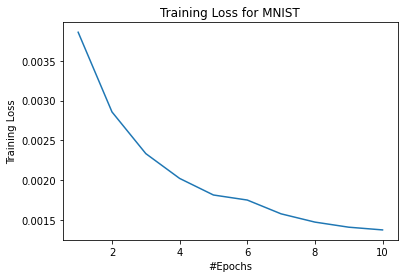

In [ ]:
plt.plot(iteration, train_loss_val)
plt.title("Training Loss for MNIST")
plt.xlabel("#Epochs")
plt.ylabel("Training Loss")
plt.show()


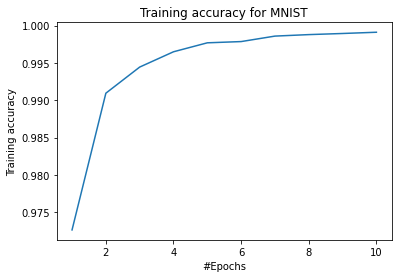

In [ ]:
plt.plot(iteration, train_acc_val)
plt.title("Training accuracy for MNIST")
plt.xlabel("#Epochs")
plt.ylabel("Training accuracy")
plt.show()


**Testing the model**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def test(capsule_net, test_loader):
    correct_class = list(0 for i in range(10))
    total_class = list(0 for i in range(10))
    a = []
    b = []
    
    test_loss = 0 # loss tracking
    capsule_net.eval() # eval mode

    for n, (inputs, target) in enumerate(test_loader):
        target = torch.eye(10).index_select(dim=0, index=target)
        batch_size = inputs.size(0)
        inputs, target = inputs.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        digicaps_out, recon, y = capsnet(inputs)
        # calculate the loss
        loss = criterion(inputs, digicaps_out, target, recon)
        # update average test loss 
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(y.data.cpu(), 1)
        _, target_shape = torch.max(target.data.cpu(), 1)

        for i in pred:
            a.append(i)
        
        for j in target_shape:
            b.append(j)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target_shape.data[i]
            correct_class[label] += correct[i].item()
            total_class[label] += 1

    a = np.array(a)
    b = np.array(b)
    cm = confusion_matrix(a,b)

    fig = plt.figure()
    ax = plt.subplot()
    sn.set(font_scale=1) # Adjust to fit
    sn.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  
    # Labels, title and ticks
    label_font = {'size':'12'}  # Adjust to fit
    ax.set_xlabel('Actual labels', fontdict=label_font);
    ax.set_ylabel('Predicted labels', fontdict=label_font);
    title_font = {'size':'12'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);
    ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
    ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']);
    ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']);
    plt.show()
    fig.savefig('cm.jpg')

    avg_test_loss = test_loss/len(test_loader)
    print('Test Loss of MNIST dataset: {:.4f}\n'.format(avg_test_loss))
    print('Test accuracy of individual classes are as follows: \n')
    for i in range(10):
        if total_class[i] > 0:
            print('Test Accuracy of class %1s: %2d%% (%2d/%2d)' % (
                str(i), 100 * correct_class[i] / total_class[i],
                np.sum(correct_class[i]), np.sum(total_class[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))
    
    # return last batch of capsule vectors, images, reconstructions
    return digicaps_out, inputs, recon


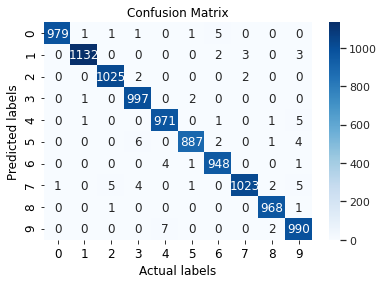

Test Loss of MNIST dataset: 0.0272

Test accuracy of individual classes are as follows: 

Test Accuracy of class 0: 99% (979/980)
Test Accuracy of class 1: 99% (1132/1135)
Test Accuracy of class 2: 99% (1025/1032)
Test Accuracy of class 3: 98% (997/1010)
Test Accuracy of class 4: 98% (971/982)
Test Accuracy of class 5: 99% (887/892)
Test Accuracy of class 6: 98% (948/958)
Test Accuracy of class 7: 99% (1023/1028)
Test Accuracy of class 8: 99% (968/974)
Test Accuracy of class 9: 98% (990/1009)

Test Accuracy (Overall): 99% (9920/10000)


In [ ]:
digicaps_out, inputs, recon = test(capsnet, test_loader)

In [ ]:
def display_images(inputs, recon):
    # convert to numpy images
    inputs = inputs.data.cpu().numpy()
    recon = recon.view(-1, 1, 28, 28)
    recon = recon.data.cpu().numpy()
    print(inputs.shape)
    print(recon.shape)
    
    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26,5))

    # input images on top row, reconstructions on bottom
    for images, row in zip([inputs, recon], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


(20, 1, 28, 28)
(20, 1, 28, 28)


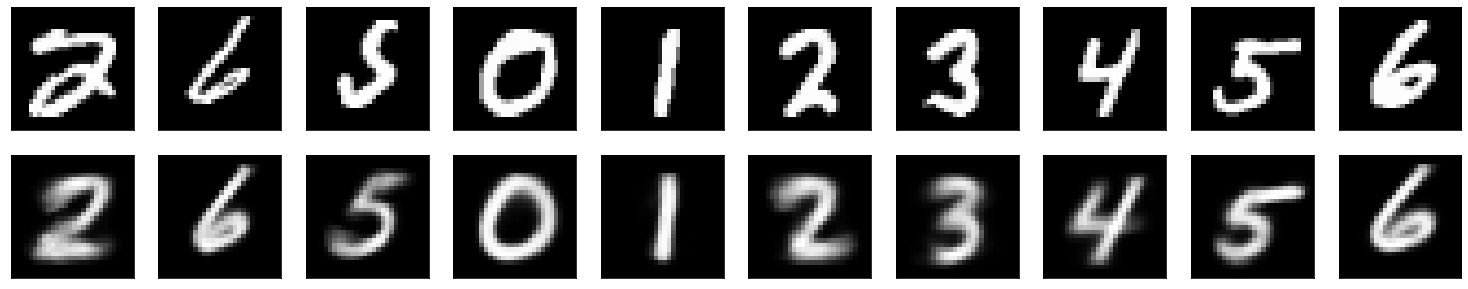

In [ ]:
display_images(inputs, recon)

**Analysis of CapsuleNets on Affine Transforms**

In [ ]:
new_transform = transforms.Compose([transforms.RandomAffine(degrees=(-10, 10), translate=(0.1,0.1), scale = (0.7, 1.3), shear = 0), transforms.ToTensor()])

# test dataset
transformed_test_data = torchvision.datasets.MNIST(root='data', train=False,
                                       download=True, transform=new_transform)

# prepare data loader
transformed_test_loader = torch.utils.data.DataLoader(transformed_test_data, batch_size=batch_size, num_workers=num_workers)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
#Random affine transform analysis with respect to rotation, translation and scaling

digicaps_out, inputs, recon = test(capsnet, transformed_test_loader)

Test Loss of MNIST dataset: 0.2341

Test accuracy of individual classes are as follows: 

Test Accuracy of class 0: 85% (834/980)
Test Accuracy of class 1: 95% (1081/1135)
Test Accuracy of class 2: 89% (924/1032)
Test Accuracy of class 3: 86% (876/1010)
Test Accuracy of class 4: 83% (818/982)
Test Accuracy of class 5: 94% (843/892)
Test Accuracy of class 6: 85% (822/958)
Test Accuracy of class 7: 89% (924/1028)
Test Accuracy of class 8: 81% (793/974)
Test Accuracy of class 9: 83% (840/1009)

Test Accuracy (Overall): 87% (8755/10000)


In [ ]:
#Don't use 

def train(capsule_net, criterion, optimizer, epochs):
    losses = []
    train_value = []
    correct_class = list(0 for i in range(10))
    total_class = list(0 for i in range(10))

    for epoch in range(1, epochs+1):
        train_loss = 0.0
        capsnet.train() # set to train mode
        # get batches of training image data and targets
        for i, (inputs, target) in enumerate(train_loader):
            # reshape and get target class
            target = torch.eye(10).index_select(dim=0, index=target)
            inputs, target = inputs.cuda(), target.cuda()
            # zero out gradients
            optimizer.zero_grad()
            # get model outputs
            digicaps_out, recon, y = capsnet(inputs)
            # calculate loss
            loss = criterion(inputs, digicaps_out, target, recon)
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() # accumulated training loss
            _, pred = torch.max(y.data.cpu(), 1)
            _, target_shape = torch.max(target.data.cpu(), 1)
            # compare predictions to true label
            correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))

            # print and record training stats
            if i != 0 and i % 300 == 0:
                avg_train_loss = train_loss/300
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0 # reset accumulated training loss
        
    return losses
